# Improvements
Current solution defines jigsaw pieces quite well. However, it still needs fixes in positioning.
That's what I want to fix here.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if not "../scripts" in sys.path:
    sys.path.append("../scripts")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
metadata = pd.read_csv("../data/metadata.csv")
puzzle_dir = "../data/puzzles"

In [5]:
from utils import *
puzzles = [
    Puzzle(int(x), os.path.join(puzzle_dir, x)) for x in os.listdir(puzzle_dir) if int(x) in metadata.puzzle_id]
puzzles = sorted(puzzles, key=lambda x: x.id)

In [6]:
#puzzle = puzzles[1]
#puzzle_data = read_puzzle(puzzle)

In [7]:
puzzle_size = {i: (h, w) for i, w, h in metadata.values}
#size = puzzle_size.get(puzzle.id)

In [8]:
LABELS = ["down", "up", "right", "left"]

label_ids = {x: i for i,x in enumerate(LABELS)}

In [9]:
# W = df['up'].sum()
# H = df['left'].sum()

In [10]:
# upleft = df.loc[df.up & df.left, 'path'].values[0]
# upright = df.loc[df.up & df.right, 'path'].values[0]
# downleft = df.loc[df.down & df.left, 'path'].values[0]
# downright = df.loc[df.down & df.right, 'path'].values[0]

# left = df.loc[df.left & ~df.up & ~df.down, 'path'].values
# right = df.loc[df.right & ~df.up & ~df.down, 'path'].values

# up = df.loc[df.up & ~df.left & ~df.right, 'path'].values
# down = df.loc[df.down & ~df.left & ~df.right, 'path'].values

# inner_nodes = df.loc[~(df.up&df.down&df.left&df.right), 'path'].values

In [11]:
from itertools import combinations

def compute_scores(df, label_ids, puzzle_data={}):
    all_scores_down = dict()
    all_scores_right = dict()
    all_paths = list(df.loc[:, "path"].values) #+ [downleft, upleft]
    align_type = 'best'

    label_a = 'down'#'right'
    label_b = 'up'#'left'
    for i, j in combinations(all_paths, 2):
        p = puzzle_data[i]
        q = puzzle_data[j]
        a = p.outer[label_ids[label_a]]
        b = q.inner[label_ids[label_b]]
        if a is not None and b is not None:
            # compare
            #plt.imshow(a)
            #plt.show()
            #plt.imshow(b)
            #plt.show()
            a = outer_transform[label_a](a)
            b = inner_transform[label_b](b)
            pair = (i, j)
            all_scores_down[pair] = match(a, b, align_type=align_type)
            #break
        a = p.inner[label_ids[label_a]]
        b = q.outer[label_ids[label_b]]
        if a is not None and b is not None:
            a = inner_transform[label_a](a)
            b = outer_transform[label_b](b)
            pair = (i, j)
            all_scores_down[pair] = match(a, b, align_type=align_type)
            #break
        # reversed
        a = q.inner[label_ids[label_a]]
        b = p.outer[label_ids[label_b]]
        if a is not None and b is not None:
            # compare
            a = inner_transform[label_a](a)
            b = outer_transform[label_b](b)
            pair = (j, i)
            all_scores_down[pair] = match(a, b, align_type=align_type)
            #break
        a = q.outer[label_ids[label_a]]
        b = p.inner[label_ids[label_b]]
        if a is not None and b is not None:
            a = outer_transform[label_a](a)
            b = inner_transform[label_b](b)
            pair = (j, i)
            all_scores_down[pair] = match(a, b, align_type=align_type)

    label_a = 'right'
    label_b = 'left'
    for i, j in combinations(all_paths, 2):
        p = puzzle_data[i]
        q = puzzle_data[j]
        a = p.outer[label_ids[label_a]]
        b = q.inner[label_ids[label_b]]

        if a is not None and b is not None:
            # compare
            #plt.imshow(a)
            #plt.show()
            #plt.imshow(b)
            #plt.show()
            a = outer_transform[label_a](a)
            b = inner_transform[label_b](b)
            pair = (i, j)
            all_scores_right[pair] = match(a, b, align_type=align_type)
            #break
        a = p.inner[label_ids[label_a]]
        b = q.outer[label_ids[label_b]]
        if a is not None and b is not None:
            a = inner_transform[label_a](a)
            b = outer_transform[label_b](b)
            pair = (i, j)
            all_scores_right[pair] = match(a, b, align_type=align_type)
            #break
        # reversed
        a = q.inner[label_ids[label_a]]
        b = p.outer[label_ids[label_b]]
        if a is not None and b is not None:
            # compare
            a = inner_transform[label_a](a)
            b = outer_transform[label_b](b)
            pair = (j, i)
            all_scores_right[pair] = match(a, b, align_type=align_type)
            #break
        a = q.outer[label_ids[label_a]]
        b = p.inner[label_ids[label_b]]
        if a is not None and b is not None:
            a = outer_transform[label_a](a)
            b = inner_transform[label_b](b)
            pair = (j, i)
            all_scores_right[pair] = match(a, b, align_type=align_type)
    return all_scores_down, all_scores_right

def compute_edges(df, label_ids, puzzle_data={}):
    all_scores_down, all_scores_right = compute_scores(df, label_ids, puzzle_data=puzzle_data)

    scores = dict()
    for (s, e), w in all_scores_down.items():
        if not s in scores:
            scores[s] = {'down': [], 'right': []}
        scores[s]['down'].append((e, w))

    for (s, e), w in all_scores_right.items():
        if not s in scores:
            scores[s] = {'down': [], 'right': []}
        scores[s]['right'].append((e, w))
    return all_scores_down, all_scores_right, scores



In [12]:
def add_node2(paths, scores, verbose=False, limit_paths=[], max_weight=200):
    for path, w0, w2 in paths:
        if verbose:
            print(path)
        s = path[-1]
        if not s in scores:
            continue
        for e, w in scores[s]['right']:
            if e in path:
                continue
            if len(limit_paths) > 0:
                if e not in limit_paths:
                    continue
            if w > max_weight:
                continue
            yield path + [e], w0+w, w2 + [w]

def get_lines(df, scores={}, max_paths=100):
    W = df['up'].sum()
    H = df['left'].sum()
    
    upleft = df.loc[df.up & df.left, 'path'].values[0]
    upright = df.loc[df.up & df.right, 'path'].values[0]
    downleft = df.loc[df.down & df.left, 'path'].values[0]
    downright = df.loc[df.down & df.right, 'path'].values[0]
    
    left = df.loc[df.left & ~df.up & ~df.down, 'path'].values
    right = df.loc[df.right & ~df.up & ~df.down, 'path'].values
    up = df.loc[df.up & ~df.left & ~df.right, 'path'].values
    down = df.loc[df.down & ~df.left & ~df.right, 'path'].values
    
    inner_nodes = df.loc[~(df.up&df.down&df.left&df.right), 'path'].values
    
    MAX_PATHS = max_paths
    lines = []
    # add first line
    line_info = [([upleft], 0, [])]
    for i in range(1, W-1):
        line_info = list(add_node2(line_info, scores, limit_paths=up))
        line_info = sorted(line_info, key=lambda x: x[1])
        if MAX_PATHS > 0:
            line_info = line_info[:MAX_PATHS]
    line_info = list(add_node2(line_info, scores, limit_paths=[upright]))
    line_info = sorted(line_info, key=lambda x: x[1])#[:100]
    if MAX_PATHS > 0:
        line_info = line_info[:MAX_PATHS]
    lines.append(line_info)

    for l in left:
        line_info = [([l], 0, [])]
        for i in range(1, W-1):
            line_info = list(add_node2(line_info, scores, limit_paths=inner_nodes))
            line_info = sorted(line_info, key=lambda x: x[1])
            if MAX_PATHS > 0:
                line_info = line_info[:MAX_PATHS]
        line_info = list(add_node2(line_info, scores, limit_paths=right))
        line_info = sorted(line_info, key=lambda x: x[1])
        if MAX_PATHS > 0:
            line_info = line_info[:MAX_PATHS]
        lines.append(line_info)

    line_info = [([downleft], 0, [])]
    for i in range(1, W-1):
        line_info = list(add_node2(line_info, scores, limit_paths=down))
        line_info = sorted(line_info, key=lambda x: x[1])
        if MAX_PATHS > 0:
            line_info = line_info[:MAX_PATHS]
    line_info = list(add_node2(line_info, scores, limit_paths=[downright]))
    line_info = sorted(line_info, key=lambda x: x[1])
    if MAX_PATHS > 0:
        line_info = line_info[:MAX_PATHS]
    lines.append(line_info)
    return lines

In [13]:
from tqdm.notebook import tqdm


def add_line(sel_lines, lines, all_scores_down={}, text=""):
    with tqdm(total=len(sel_lines), leave=False) as pbar:
        i = 0
        for prev_lines, prev_w, wdetailed in sel_lines:
            seen_paths = [x for xs in prev_lines for x in xs[0]]
            seen_paths = set(seen_paths)
            if len(prev_lines[-1])!=3:
                print(prev_lines[-1])
            prev_line, prev_weight, cum_weight = prev_lines[-1]
            for data in lines:
                line, w_line, w_c = data
                if np.any([ (path in seen_paths) for path in line]):
                    continue
                score_w = 0
                for a, b in zip(prev_line, line):
                    if not (a, b) in all_scores_down:
                        score_w = -1
                        break
                    score_w += all_scores_down[(a, b)]
                if score_w < 0:
                    continue
                yield prev_lines+[data], score_w + prev_w + w_line, wdetailed+[score_w, w_line]
            i += 1
            if i >= 20:
                pbar.update(i)
                pbar.set_description(text)
                i = 0
        if i > 0:
            pbar.update(i)
            
                    

In [14]:
def combine_lines(df, lines, all_scores_down={}, text=""):
    W = df['up'].sum()
    H = df['left'].sum()
    starts = [([l], l[1], [l[1]]) for l in lines[0]]
    middle = [x for xs in lines[1:-1] for x in xs]
    for j in range(1, H-1):
        starts = list(add_line(starts, middle, all_scores_down=all_scores_down,
                               text=f"{text} {j}"))
        starts = sorted(starts, key=lambda x: x[1])
        starts = starts[:1000]
    starts = list(add_line(starts, lines[-1], all_scores_down=all_scores_down,
                           text=f"{text} {H-1}"))
    starts = sorted(starts, key=lambda x: x[1])
    return starts

def solve_puzzle(df, all_scores_down, scores={}, max_paths=100, text=""):
    lines = get_lines(df, scores=scores, max_paths=max_paths)
    starts = combine_lines(df, lines, all_scores_down=all_scores_down, text=text)
    return starts

In [15]:
def draw_with_offset(target, piece, offset):
    hmax, wmax = target.shape
    h, w = offset
    pos = np.argwhere(piece.contour>0)
    hcoord = pos[:, 0]
    wcoord = pos[:, 1]
    target[(hcoord+h) % hmax, (wcoord+w)%wmax, :] = piece.img[hcoord, wcoord, :]

def draw_puzzle(collection, size, H, W, puzzle_data={}):
    target_img = np.zeros(size+(4,), dtype=np.uint8)
    h, w = size
    hstep = h/collection.height
    wstep = w/collection.width
    offsets_table = []
    for i, line in enumerate(collection.field):
        offsets = []
        for j, path in enumerate(line):
            offset_h = hstep/2 + hstep*i
            offset_w = wstep/2 + wstep*j
            h_, w_ = puzzle_data[path].img.shape[:2]
            offset_h -= h_/2
            offset_w -= w_/2
            offset_h = max(int(offset_h), 0)
            offset_w = max(int(offset_w), 0)
            if i == H-1:
                offset_h = h - h_
            if j == W - 1:
                offset_w = w - w_
            offsets.append((offset_h, offset_w))
            draw_with_offset(target_img, puzzle_data[path], (offset_h, offset_w))
        offsets_table.append(offsets)
    return target_img

In [16]:
def draw_puzzle_to_file(df, puzzle_data, solutions, size=(0, 0), savedir=".", puzzle_id=0):
    W = df['up'].sum()
    H = df['left'].sum()
    collection = Collection(H, W, puzzle_data)
    for i, line in enumerate(solutions[0][0]):
        for j, x in enumerate(line[0]):
            collection.fill(i, j, x)

    cv2.imwrite(os.path.join(savedir, f"{puzzle_id}.jpg"),
                draw_puzzle(collection, size, H, W, puzzle_data=puzzle_data)[:, :, :3])

In [17]:
def find_solution_for(puzzle, puzzle_size, savedir="temp", max_paths=100, force=False):
    path = os.path.join(savedir, f"{puzzle.id}.jpg")
    if os.path.exists(path) and not force:
        return
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    size = puzzle_size.get(puzzle.id)
    puzzle_data = read_puzzle(puzzle)
    item_info = []
    for path, item in puzzle_data.items():
        info = {l: x is None and y is None for x, y, l in zip(item.inner, item.outer, LABELS)}
        info['path'] = path
        item_info.append(info)
    df = pd.DataFrame(item_info)
    all_scores_down, all_scores_right, scores = compute_edges(df, label_ids, puzzle_data=puzzle_data)
    text = f"Solving {puzzle.id}:"
    starts = solve_puzzle(df, all_scores_down, scores=scores, max_paths=max_paths, text=text)
    if len(starts) == 0:
        starts = solve_puzzle(df, all_scores_down, scores=scores, max_paths=1000, text=text)
    
    draw_puzzle_to_file(df, puzzle_data, starts, size=size, savedir=savedir, puzzle_id = puzzle.id)
    

In [18]:
for puzzle in tqdm(puzzles):
    break
    find_solution_for(puzzle, puzzle_size)

In [19]:
puzzle = puzzles[4]

In [20]:
savedir="newdir"
max_paths=100
path = os.path.join(savedir, f"{puzzle.id}.jpg")

if not os.path.exists(savedir):
    os.makedirs(savedir)
size = puzzle_size.get(puzzle.id)
puzzle_data = read_puzzle(puzzle)
item_info = []
for path, item in puzzle_data.items():
    info = {l: x is None and y is None for x, y, l in zip(item.inner, item.outer, LABELS)}
    info['path'] = path
    item_info.append(info)
df = pd.DataFrame(item_info)
all_scores_down, all_scores_right, scores = compute_edges(df, label_ids, puzzle_data=puzzle_data)
text = f"Solving {puzzle.id}:"
starts = solve_puzzle(df, all_scores_down, scores=scores, max_paths=max_paths, text=text)
if len(starts) == 0:
    starts = solve_puzzle(df, all_scores_down, scores=scores, max_paths=1000, text=text)

In [21]:
solution = starts[0][0]

In [22]:
W = df['up'].sum()
H = df['left'].sum()
collection = Collection(H, W, puzzle_data)
for i, line in enumerate(starts[0][0]):
    for j, x in enumerate(line[0]):
        collection.fill(i, j, x)

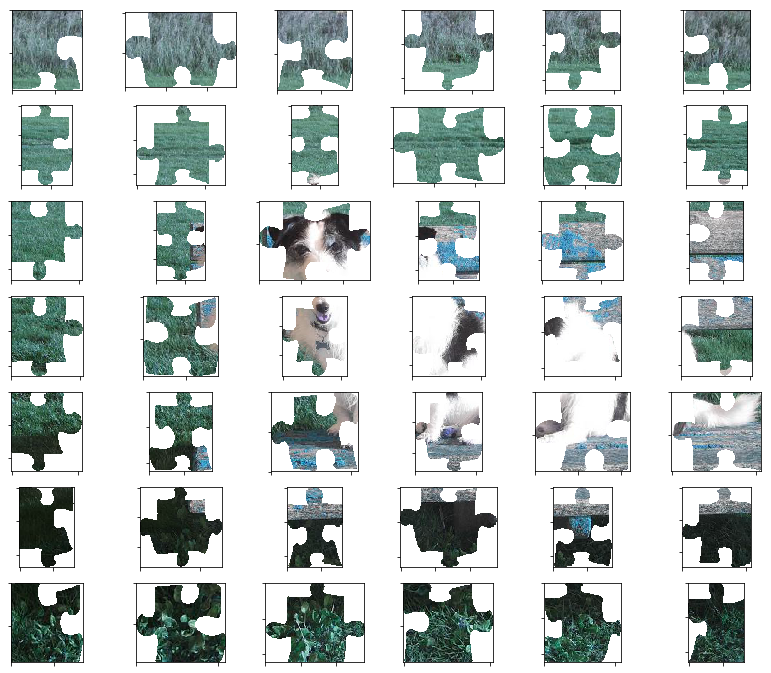

In [23]:
collection.draw()

In [24]:
def draw_with_offset(target, piece, offset):
    hmax, wmax = target.shape[:2]
    h, w = offset
    pos = np.argwhere(piece.contour>0)
    hcoord = pos[:, 0]
    wcoord = pos[:, 1]
    target[(hcoord+h)%hmax, (wcoord+w)%wmax, :] = piece.img[hcoord, wcoord, :]

def draw_puzzle(collection, size, H, W, puzzle_data={}):
    target_img = np.zeros(size+(4,), dtype=np.uint8)
    h, w = size
    hstep = h/collection.height
    wstep = w/collection.width
    offsets_table = []
    for i, line in enumerate(collection.field):
        offsets = []
        for j, path in enumerate(line):
            offset_h = hstep/2 + hstep*i
            offset_w = wstep/2 + wstep*j
            h_, w_ = puzzle_data[path].img.shape[:2]
            offset_h -= h_/2
            offset_w -= w_/2
            offset_h = max(int(offset_h), 0)
            offset_w = max(int(offset_w), 0)
            if i == H-1:
                offset_h = h - h_
            if j == W - 1:
                offset_w = w - w_
            offsets.append((offset_h, offset_w))
            draw_with_offset(target_img, puzzle_data[path], (offset_h, offset_w))
        offsets_table.append(offsets)
    return target_img

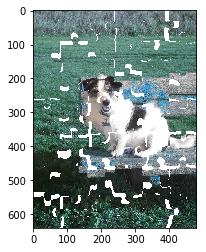

In [25]:
plt.imshow(draw_puzzle(collection, size, H, W, puzzle_data))

In [26]:
#left = collection.field[1][1]
#right = collection.field[1][2]

In [27]:
#left = puzzle_data[left]
#right = puzzle_data[right]

In [28]:
#plt.imshow(left.img)

In [29]:
#plt.imshow(left.inner[label_ids['right']])

In [30]:
#plt.imshow(right.outer[label_ids['left']])

In [31]:
#a = inner_transform["right"](left.inner[label_ids['right']])
#b = outer_transform["left"](right.outer[label_ids['left']])

In [32]:
#data = match(a, b, show=False, return_coords=True)

In [33]:
#data[0]

In [34]:
#m1, m2, h, c1, c2 = data[1:]

In [35]:
#m1, m2

In [36]:
#plt.imshow(a[m1[0]:m1[0]+h, m1[1]+c1:])

In [37]:
#plt.imshow(b[m2[0]:m2[0]+h, m2[1]+c2:])

In [38]:
coord_inner_transform = {
    'down': lambda x, y, size: (x, y),
    'up': lambda x, y, size: (size[0] - x, size[1] - y),
    'right': lambda x, y, size: (size[0] - y, x),
    'left': lambda x, y, size: (y, size[1] - x)
}
coord_outer_transform = {
    'down': lambda x, y, size: (size[0] - x, size[1] - y),
    'up': lambda x, y, size: (x, y),
    'right': lambda x, y, size: (y, size[1] - x),
    'left': lambda x, y, size: (size[0] - y, x)
}

In [39]:
#pos = coord_inner_transform['right'](m1[0], m1[1]+c1)

In [40]:
#plt.imshow(left.inner[2][pos[0]:, pos[1]:])

In [41]:
def find_horizontal_offsets(left, right, verbose=True):
    a = left.inner[label_ids['right']]
    b = right.outer[label_ids['left']]
    s1 = left.img.shape[:2]
    s2 = right.img.shape[:2]
    if a is not None and b is not None:
        a = inner_transform["right"](a)
        b = outer_transform["left"](b)
        diff, m1, m2, h, c1, c2 = match(a, b, show=False, return_coords=True)
        pos1 = coord_inner_transform['right'](m1[0], m1[1] + c1, s1)
        pos2 = coord_outer_transform['left'](m2[0], m2[1] + c2, s2)
    else:
        a = left.outer[label_ids['right']]
        b = right.inner[label_ids['left']]
        if a is not None and b is not None:
            a = outer_transform["right"](a)
            b = inner_transform["left"](b)
            diff, m1, m2, h, c1, c2 = match(a, b, show=False, return_coords=True)
            pos1 = coord_outer_transform['right'](m1[0], m1[1] + c1, s1)
            pos2 = coord_inner_transform['left'](m2[0], m2[1] + c2, s2)
        else:
            raise f"invalid image pair {left.path}, {right.path}"
    #s1 = left.img.shape[:2]
    #pos1 = [(i if i >= 0 else s-i) for i, s in zip(pos1, s1)]
    #s2 = right.img.shape[:2]
    #pos2 = [(i if i >= 0 else s-i) for i, s in zip(pos2, s2)]
    return pos1, pos2

def find_vertical_offsets(up, down, verbose=True):
    a = up.inner[label_ids['down']]
    b = down.outer[label_ids['up']]
    s1 = up.img.shape[:2]
    s2 = down.img.shape[:2]
    #print("smth", a, b)
    if a is not None and b is not None:
        a = inner_transform["down"](a)
        b = outer_transform["up"](b)
        diff, m1, m2, h, c1, c2 = match(a, b, show=False, return_coords=True)
        #print(111)
        pos1 = coord_inner_transform['down'](m1[0], m1[1] + c1, s1)
        pos2 = coord_outer_transform['up'](m2[0], m2[1] + c2, s2)
    else:
        a = up.outer[label_ids['down']]
        b = down.inner[label_ids['up']]
        if a is not None and b is not None:
            a = outer_transform["down"](a)
            b = inner_transform["up"](b)
            diff, m1, m2, h, c1, c2 = match(a, b, show=False, return_coords=True)
            #print(222)
            pos1 = coord_outer_transform['down'](m1[0], m1[1] + c1, s1)
            pos2 = coord_inner_transform['up'](m2[0], m2[1] + c2, s2)
        else:
            raise f"invalid image pair (vertical) {up.path}, {down.path}"
    #s1 = up.img.shape[:2]
    #pos1 = [(i if i > 0 else s-i) for i, s in zip(pos1, s1)]
    #s2 = down.img.shape[:2]
    #pos2 = [(i if i > 0 else s-i) for i, s in zip(pos2, s2)]
    return pos1, pos2

In [42]:
def get_collection_offsets(collection, item_offsets):
    offsets = dict()
    offsets[collection.field[0][0]] = [0,0]
    for i, line in enumerate(collection.field):
        #print(line)
        if not line[0] in offsets and i > 0:
            up = collection.field[i-1][0]
            offset1 = item_offsets['down'][up]
            offset2 = item_offsets['up'][line[0]]
            htop, wtop = offsets[up]
            offsets[line[0]] = [(htop + offset1[0]-offset2[0]) %size[0],
                                (wtop + offset1[1]-offset2[1]) %size[1]]
        for left, right in zip(line, line[1:]):
            x, y = offsets[left]
            offset1 = item_offsets['right'][left]
            offset2 = item_offsets['left'][right]
            offsets[right] = [x + offset1[0] - offset2[0], y + offset1[1]-offset2[1]]
    return offsets

In [43]:
def get_item_offsets(collection, puzzle_data, LABELS):
    item_offsets = {l:dict() for l in LABELS}
    for i, line in enumerate(collection.field):
        for j, item in enumerate(line):
            if j > 0:
                left = collection.field[i][j-1]
                right = collection.field[i][j]
                offset1, offset2 = find_horizontal_offsets(puzzle_data[left], puzzle_data[right])
                item_offsets['right'][left] = offset1
                item_offsets['left'][right] = offset2
            if i > 0:
                up = collection.field[i-1][j]
                down = collection.field[i][j]
                offset1, offset2 = find_vertical_offsets(puzzle_data[up], puzzle_data[down])
                item_offsets['down'][up] = offset1
                item_offsets['up'][down] = offset2
    return item_offsets

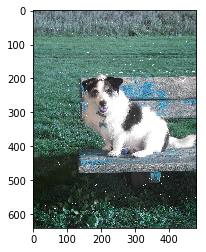

In [44]:
item_offsets = get_item_offsets(collection, puzzle_data, LABELS)
offsets = get_collection_offsets(collection, item_offsets)

target_img =np.zeros(size+(4,), dtype=np.uint8)
for line in collection.field:
    for x in line:
        draw_with_offset(target_img, puzzle_data[x], offsets[x])
plt.imshow(target_img)

In [45]:
def draw_puzzle_to_file2(df, puzzle_data, solutions, size=(0, 0), savedir="newdir", puzzle_id=0, fill_gaps=True):
    W = df['up'].sum()
    H = df['left'].sum()
    collection = Collection(H, W, puzzle_data)
    for i, line in enumerate(solutions[0][0]):
        for j, x in enumerate(line[0]):
            collection.fill(i, j, x)
    item_offsets = get_item_offsets(collection, puzzle_data, LABELS)
    offsets = get_collection_offsets(collection, item_offsets)
    
    target_img = np.zeros(size+(4,), dtype=np.uint8)
    for line in collection.field:
        for x in line:
            draw_with_offset(target_img, puzzle_data[x], offsets[x])
    if fill_gaps:
        fill_gaps_in_image(target_img)

    cv2.imwrite(os.path.join(savedir, f"{puzzle_id}.jpg"),
                target_img[:, :, :3])
    return target_img

def find_solution2_for(puzzle, puzzle_size, savedir="newdir", max_paths=100, force=False, fill_gaps=True):
    path = os.path.join(savedir, f"{puzzle.id}.jpg")
    if os.path.exists(path) and not force:
        return
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    size = puzzle_size.get(puzzle.id)
    puzzle_data = read_puzzle(puzzle)
    item_info = []
    for path, item in puzzle_data.items():
        info = {l: x is None and y is None for x, y, l in zip(item.inner, item.outer, LABELS)}
        info['path'] = path
        item_info.append(info)
    df = pd.DataFrame(item_info)
    all_scores_down, all_scores_right, scores = compute_edges(df, label_ids, puzzle_data=puzzle_data)
    text = f"Solving {puzzle.id}:"
    starts = solve_puzzle(df, all_scores_down, scores=scores, max_paths=max_paths, text=text)
    if len(starts) == 0:
        starts = solve_puzzle(df, all_scores_down, scores=scores, max_paths=1000, text=text)
    
    return draw_puzzle_to_file2(df, puzzle_data, starts, size=size, savedir=savedir, puzzle_id = puzzle.id,
                                fill_gaps=fill_gaps)
    

In [46]:
from sklearn.neighbors import NearestNeighbors

def fill_gaps_in_image(target_img, kneighbours=4):
    nnz = np.argwhere(target_img[:, :, 3] != 0)
    zeros = np.argwhere(target_img[:, :, 3] == 0)
    nbrs = NearestNeighbors(n_neighbors=kneighbours, algorithm='ball_tree').fit(nnz)
    distances, indices = nbrs.kneighbors(zeros)
    for (x, y), coords in zip(zeros, indices):
        c = nnz[coords]
        mean_coords = target_img[c[:, 0], c[:, 1]].mean(0).astype(np.uint8)
        target_img[x, y] = mean_coords
    return target_img

In [47]:
for puzzle in tqdm(puzzles):
    target_img = find_solution2_for(puzzle, puzzle_size, savedir="newdir", fill_gaps=True)

In [48]:
#item_offsets